### Introducción
El objetivo de este notebook es demostrar una aproximación al análisis de series temporales mediante el uso del framework para Deep Learning **tensorflow** y sus APIs ya estables: `Dataset` y `Estimator` que parecen establecer un estándar dentro del propio framework para abordar problemas de aprendizaje supervisado en general.

### Requisitos
El presente notebook se ha desarrollado con,
* Python 3.5
* numpy 1.14.0
* matplotlib 2.1.1
* pandas 0.22.0
* tensorflow 1.4

### Dataset
El dataset sobre el cual se trabajará consta de varios ficheros. A continuación se describirán los utilizados,
* **all.txt**, contiene datos para cada hora sobre los precios de distintos tipos de combustibles medidos en 10233 gasolineras de toda España. Cada registro contiene además datos propios de cada gasolinera (grupo al que pertenece, dirección, horario...). Contiene además la variable target: *precio_sig* que es el precio del diesel en la siguiente hora. Para cada gasolinera se proporciona una serie temporal de como máximo 641 registros (ó lo que es lo mismo 641 horas≈27 días). Es un fichero de giga y medio de tamaño con lo que manejarlo en local es posible pero pesado. Se proporciona un versión reducida para el estudio previo de los datos **all_lite.txt**
* **change.txt**, contiene el histórico del precio de cierre diario para el tipo de cambio EUR/USD.
* **brent.txt**, contiene el histórico de distintos parámetros diarios de mercado relativos al barril de petróleo Brent (por ejemplo precio de apertura, máximo, mínimo, de cierre...)

### Preparando el entorno de trabajo
Dentro del directorio en el que se deposite este notebook,
* Se creará la carpeta `datasets`.
* Dentro de la carpeta `datasets` se creará la carpeta `diesel`.
* Dentro de la carpeta `diesel` se depositará `all.txt.gz`, `change.txt` y `brent.txt`.

### Manos a la obra
Vamos a preparar una pequeña función (`fetch_data`) para descomprimir y volcar el contenido en un fichero que luego podamos manejar.
Para ello utilizaremos algunas librerías que nos serán de utilidad como `gzip` y `os`

In [65]:
import gzip
import os

In [66]:
# gzipped all.txt
PRECIO_DIESEL_FILENAME="all.txt.gz"
# parent directory
DATASET_DIR="C:\\Cursos\\DeepLearning_TF-master\\datasets\\"
# this dataset directory
PRECIO_DIESEL_DATASET_DIR="diesel"

In [67]:
def fetch_data(data_path, data_filename):
    """
    Function that receives a path and a gzipped file name
    and opens it to dump its content into a new file whose
    name will be the same as the original gzipped file but with 
    the compression extension stripped.
    Args:
        - data_path: path of the gzipped file.
        - data_filename: name of the gzipped file.
    Returns:
        - ugz_path: the absolute path of the gzipped file
    
    
    """
    if not os.path.isdir(data_path):
        print(data_path,"does not exist, it will be created...")
        os.makedirs(data_path)
        print(data_path,"created!")
        print("Be sure "+data_filename+" is in the path!")
    gz_path = os.path.join(data_path, data_filename)
    try:
        with gzip.open(gz_path, 'rb') as f:
            gzip_content = f.read()
            f.close()
        print(gz_path)
    except FileNotFoundError:
        print("File not found!")
            
    
    ugz_path_list = gz_path.split('.')[:-1]
    ugz_path = '.'.join(ugz_path_list)
    
    with open(ugz_path, 'wb') as u:
        u.write(gzip_content)
        u.close()
           
    print("Ungzipped to "+ugz_path)
    print("Complete!")    
    
    return ugz_path

In [68]:
precios_diesel_txt = fetch_data(DATASET_DIR+PRECIO_DIESEL_DATASET_DIR, PRECIO_DIESEL_FILENAME)

C:\Cursos\DeepLearning_TF-master\datasets\diesel\all.txt.gz
Ungzipped to C:\Cursos\DeepLearning_TF-master\datasets\diesel\all.txt
Complete!


Ya es momento de cargar el fichero en un dataframe de `pandas` y su método `read_csv`. Aquí tenemos dos opciones:
* Dejar que Python infiera el `dtypes` esto se conseguiría no especificando este parámetro al método `read_csv`. Es más cómodo pero a cambio Python considerará todos aquellos tipos de dato numéricos como `float64` y aquellos que no sean estrictamente numéricos como `object` lo que se traducirá en una mayor consumo de RAM.
* Explorar previamente la versión lite del fichero a cargar para estudiar los valores entre los que se mueve cada campo, segúramente no todos ellos precisen de un tipo `float64` y para otros el tipo `object` no es el más óptimo. Una vez hecho el estudio, especificaremos mediante el campo `dtype` un diccionario con el tipo a utilizar para cargar cada campo.

In [69]:
import numpy as np
import pandas as pd

In [70]:
precios_diesel_df = pd.read_csv(filepath_or_buffer=precios_diesel_txt,\
                                    dtype={"ideess":np.int16,"hora":np.uint8,"remision":"category","precio":np.float16,\
                                           "precio_premium":np.float16,"precio_gasolina_95":np.float16,"precio_ant":np.float16,\
                                           "precio_sig":np.float16,"diff_premium":np.float16,"diff_ant":np.float16,\
                                           "ind_cambio":np.float16,"ind_diff":np.float16,"ind_diff_sig":np.float16,"diff_sig":np.float16,\
                                           "grupo":"category","ind_24h":"category","codpos":np.uint16,"idccaa":np.uint8,"idmunicipio":np.uint16,\
                                           "idprovincia":np.uint8,"latitud":np.float16,"longitud":np.float16,"margen":"category",\
                                           "ind_intradia":"category","max_cambios":np.float16,"min_cambios":np.float16,"avg_cambios":np.float16},\
                                    sep='|', 
                                    parse_dates=['dia','fecha'],
                                    infer_datetime_format=True)

Vamos a hacer el estudio con los precios de una sola gasolinera, recordemos que queremos utilizar series temporales entonces no podemos seleccionar todas las gasolineras ya que el periodo de tiempo que cubren es similar, nos centraremos pues en una. Se escoge por ejemplo aquella cuya *ideess* es *4094*, porque se tiene constancia de que la serie temporal para ella comprende el máximo de registros recogidos por estación: 641

In [71]:
ideess = 4094
precios_diesel_df_series = precios_diesel_df[precios_diesel_df["ideess"] == ideess].sort_values(by="fecha", ascending=True)

Vemos como los registros han sido ordenados de menor a mayor de manera que el más antiguo empieza el 20 de diciembre de 2017 a las 14 horas.

In [72]:
precios_diesel_df_series.head(n=3)

,ideess,dia,hora,rotulo,horario,remision,precio,precio_premium,precio_gasolina_95,precio_ant,...,provincia,localidad,latitud,longitud,margen,municipio,ind_intradia,max_cambios,min_cambios,avg_cambios
3718567,4094,2017-12-20,14,REPSOL,L-D: 24H,OM,1.189453,1.239258,1.289062,NaN,...,VALENCIA / VALÈNCIA,CAUDETE DE LAS FUENTES,39.53125,-1.311523,D,Caudete de las Fuentes,0,1.0,0.0,0.0
3718568,4094,2017-12-20,15,REPSOL,L-D: 24H,OM,1.189453,1.239258,1.289062,1.189453,...,VALENCIA / VALÈNCIA,CAUDETE DE LAS FUENTES,39.53125,-1.311523,D,Caudete de las Fuentes,0,1.0,0.0,0.0
3718569,4094,2017-12-20,16,REPSOL,L-D: 24H,OM,1.189453,1.239258,1.289062,1.189453,...,VALENCIA / VALÈNCIA,CAUDETE DE LAS FUENTES,39.53125,-1.311523,D,Caudete de las Fuentes,0,1.0,0.0,0.0


Siempre es bueno visualizar aquellas features numéricas, de manera que podamos hacernos una idea de como se mueven a lo largo del tiempo.

In [73]:
%matplotlib inline
from matplotlib import pyplot as plt

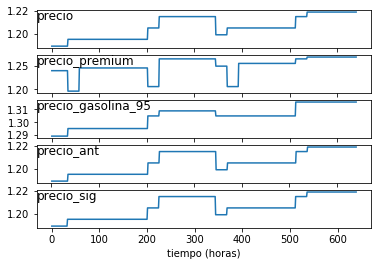

In [74]:
columns = ["precio","precio_premium","precio_gasolina_95","precio_ant","precio_sig"]

plt.figure()
for idx,col in enumerate(columns):
    plt.subplot(len(columns),1,idx+1)
    plt.plot(precios_diesel_df_series[col].values)
    plt.title(col, y=0.6, loc='left')
    plt.xlabel("tiempo (horas)")
plt.show()

Después de ejecutar un pandas profiling sobre el dataset y dado que lo que se va a tener en cuenta para el análisis de series temporales son datos que varian en el tiempo. Realizamos un primer descarte de features:

In [75]:
drop_list = ['ccaa','codpos','diff_ant','diff_sig','direccion','fecha','grupo',\
             'horario','idccaa','ideess','idmunicipio','idprovincia','ind_cambio',\
             'ind_cambio_sig','ind_intradia','latitud','localidad','longitud','margen',\
             'max_cambios','min_cambios','municipio','precio_ant','provincia','remision','rotulo']

precios_diesel_df_series = precios_diesel_df_series.drop(columns=drop_list,inplace=False)

In [76]:
precios_diesel_df_series = precios_diesel_df_series[[c for c in precios_diesel_df_series if c not in ['precio_sig']] + ['precio_sig']]

### Tipo de cambio EUR/USD
Es el momento de cargar en un dataframe de `pandas` el fichero de tipos de cambio.

In [77]:
PRECIO_EURUSD_FILENAME="C:\\Cursos\\DeepLearning_TF-master\\datasets\\diesel\\change.txt"

In [78]:
precios_eurusd_df = pd.read_csv(filepath_or_buffer=PRECIO_EURUSD_FILENAME,\
                                dtype={"eur_usd":np.float32},\
                                sep='|',\
                                parse_dates=['fecha'],\
                                infer_datetime_format=True)

Hay que tener en cuenta que los precios del fichero all.txt son diarios, incluyendo fines de semana y festivos. Entonces si queremos emparejar cada uno de los días disponibles con el correspondiente tipo de cambio, tendremos que cerciorarnos de proveer precio todos los días para este último. Para ello vamos a rellenar los huecos ocasionados por fines de semana y festivos repitiendo el último precio disponible (por ejemplo tomando el precio del viernes y aplicándolo al sábado y domingo siguientes). Esto es lo que se conoce como **resample**

In [79]:
# The date feature is set as the dataframe index to enable resampling.
precios_eurusd_df["fecha"] = pd.to_datetime(precios_eurusd_df["fecha"],format="%Y/%m/%d")
precios_eurusd_df = precios_eurusd_df.sort_values(["fecha"], ascending=[True])
precios_eurusd_df.set_index("fecha",inplace=True)

In [80]:
# Now the dataframe is indexed by date
precios_eurusd_df.head(n=3)

,eur_usd
fecha,
2017-01-29,1.0717
2017-01-30,1.0708
2017-01-31,1.0801


In [81]:
# Time to resample, D value indicates that resampling will be done at day level (there 
# is a wide choice of rules to apply here) however we are OK with a plain daily basis
# We also get rid of the index once the sampling is done.
precios_eurusd_df = precios_eurusd_df.resample("D").ffill().reset_index()

In [82]:
# The gaps have been filled
precios_eurusd_df.tail(10)

,fecha,eur_usd
352,2018-01-16,1.2271
353,2018-01-17,1.2180
354,2018-01-18,1.2234
355,2018-01-19,1.2223
356,2018-01-20,1.2223
357,2018-01-21,1.2256
358,2018-01-22,1.2256
359,2018-01-23,1.2309
360,2018-01-24,1.2393
361,2018-01-25,1.2392


Si vamos a incluir el tipo de cambio en nuestro dataset cargado de all.txt, hemos de tener en cuenta que a la hora de hacer una predicción sobre el precio de la hora siguiente tendremos que incluir también la feature tipo de cambio, la única manera de poder hacer esto es considerar para cada día de all.txt el tipo de cambio del día anterior: es decir el día 17 de enero sabemos seguro cual fue el tipo cambio final para el día 16 de enero.
Por ello vamos a crear una nueva feature en el dataset del tipo de cambio que indique que la fecha en la que aplicaremos cada tipo de cambio, será un día después de la fecha de cierre del mismo.

In [83]:
precios_eurusd_df["fecha_join"] = precios_eurusd_df["fecha"] + pd.to_timedelta(1,unit="d")

In [84]:
# Now we have the effective date for each fx close price but also the date
# when it will be used in our all.txt dataset.
precios_eurusd_df.tail(3)

,fecha,eur_usd,fecha_join
359,2018-01-23,1.2309,2018-01-24
360,2018-01-24,1.2393,2018-01-25
361,2018-01-25,1.2392,2018-01-26


### Precios barril de Brent
Ahora cargaremos en un dataframe de `pandas` el histórico de precios del barril de Brent. El procedimiento será prácticamente idéntico al seguido con el tipo de cambio, con la diferencia de que para el barril de Brent disponemos de más features.

In [85]:
PRECIO_BRENT_FILENAME="C:\\Cursos\\DeepLearning_TF-master\\datasets\\diesel\\brent.txt"

De nuevo, le damos ya los dtype a Python de manera que no tenga que inferirlos. Préviamente a esto hemos revisado el pandas profiling para poder adecuar los dtype a cada feature.

In [86]:
precios_brent_df = pd.read_csv(filepath_or_buffer=PRECIO_BRENT_FILENAME,\
                                    dtype={"open":np.float16,"high":np.float16,"low":np.float16,"settle":np.float16,\
                                           "change":np.float16,"wave":np.float16,"volume":np.float32,\
                                           "prev_day_open_interest":np.float32,"efp_volume":np.float32,"efs_volume":np.float16,\
                                           "block_volume":np.float16},\
                                    sep='|',\
                                    parse_dates=['fecha'],\
                                    infer_datetime_format=True)

Formateamos y establecemos la fecha como índice del dataframe de manera que posteriormente podamos efectuar un resampling de forma similar a como se hizo en el caso del fichero de tipos de cambio.

In [87]:
precios_brent_df["fecha"] = pd.to_datetime(precios_brent_df["fecha"], format="%Y/%m/%d")
precios_brent_df = precios_brent_df.sort_values(by=["fecha"], ascending=[True])
precios_brent_df.set_index("fecha", inplace=True)

In [88]:
precios_brent_df.head()

,open,high,low,settle,change,wave,volume,prev_day_open_interest,efp_volume,efs_volume,block_volume
fecha,,,,,,,,,,,
1993-03-17,18.796875,18.796875,18.796875,18.796875,NaN,NaN,0.0,0.0,NaN,NaN,NaN
1993-03-18,18.875000,18.875000,18.875000,18.875000,NaN,NaN,0.0,0.0,NaN,NaN,NaN
1993-03-19,18.890625,18.890625,18.890625,18.890625,NaN,NaN,0.0,0.0,NaN,NaN,NaN
1993-03-22,18.500000,18.500000,18.500000,18.500000,NaN,NaN,0.0,0.0,NaN,NaN,NaN
1993-03-23,18.609375,18.609375,18.609375,18.609375,NaN,NaN,0.0,0.0,NaN,NaN,NaN


In [89]:
precios_brent_df = precios_brent_df.resample('D').ffill().reset_index()

In [90]:
# Check the resampling
precios_brent_df.head()

,fecha,open,high,low,settle,change,wave,volume,prev_day_open_interest,efp_volume,efs_volume,block_volume
0,1993-03-17,18.796875,18.796875,18.796875,18.796875,NaN,NaN,0.0,0.0,NaN,NaN,NaN
1,1993-03-18,18.875000,18.875000,18.875000,18.875000,NaN,NaN,0.0,0.0,NaN,NaN,NaN
2,1993-03-19,18.890625,18.890625,18.890625,18.890625,NaN,NaN,0.0,0.0,NaN,NaN,NaN
3,1993-03-20,18.890625,18.890625,18.890625,18.890625,NaN,NaN,0.0,0.0,NaN,NaN,NaN
4,1993-03-21,18.890625,18.890625,18.890625,18.890625,NaN,NaN,0.0,0.0,NaN,NaN,NaN


Ahora obtendremos la fecha en la que asociaremos cada precio del barril Brent a su correspondiente registro en all.txt

In [91]:
precios_brent_df["fecha_join"] = precios_brent_df["fecha"] + pd.to_timedelta(1, unit='d')

### Fusionando (merge) los dataframe `precios_diesel_df_series`, `precios_eurusd_df` y `precios_brent_df`
Ahora es cuando uniremos los tres dataframe en base a los ajustes de fecha que hemos hecho en `precios_eurusd_df` y `precios_brent_df` apoyándonos en las features `fecha_join` que hemos ido creando con la fecha que utilizaremos para unir ambos dataframes con `precios_diesel_df_series`.

In [92]:
# First we'll join precios_diesel_df_series with precios_brent_df
precios_diesel_brent_df = precios_diesel_df_series.merge(right=precios_brent_df, how='left', left_on=["dia"], right_on=["fecha_join"])

In [93]:
precios_diesel_brent_df.head()

,dia,hora,precio,precio_premium,precio_gasolina_95,diff_premium,ind_diff,ind_diff_sig,ind_24h,avg_cambios,...,low,settle,change,wave,volume,prev_day_open_interest,efp_volume,efs_volume,block_volume,fecha_join
0,2017-12-20,14,1.189453,1.239258,1.289062,50.0,NaN,0.0,1,0.0,...,63.3125,63.8125,0.389893,63.65625,205423.0,260457.0,1807.0,NaN,5960.0,2017-12-20
1,2017-12-20,15,1.189453,1.239258,1.289062,50.0,0.0,0.0,1,0.0,...,63.3125,63.8125,0.389893,63.65625,205423.0,260457.0,1807.0,NaN,5960.0,2017-12-20
2,2017-12-20,16,1.189453,1.239258,1.289062,50.0,0.0,0.0,1,0.0,...,63.3125,63.8125,0.389893,63.65625,205423.0,260457.0,1807.0,NaN,5960.0,2017-12-20
3,2017-12-20,17,1.189453,1.239258,1.289062,50.0,0.0,0.0,1,0.0,...,63.3125,63.8125,0.389893,63.65625,205423.0,260457.0,1807.0,NaN,5960.0,2017-12-20
4,2017-12-20,18,1.189453,1.239258,1.289062,50.0,0.0,0.0,1,0.0,...,63.3125,63.8125,0.389893,63.65625,205423.0,260457.0,1807.0,NaN,5960.0,2017-12-20


In [94]:
# Then we'll do the same with the resulting dataframe and the fx EUR/USD dataframe
precios_diesel_brent_eurusd_df = precios_diesel_brent_df.merge(right=precios_eurusd_df, how='left', left_on=["fecha_join"], right_on=["fecha_join"])

In [95]:
precios_diesel_brent_eurusd_df.head(3)

,dia,hora,precio,precio_premium,precio_gasolina_95,diff_premium,ind_diff,ind_diff_sig,ind_24h,avg_cambios,...,change,wave,volume,prev_day_open_interest,efp_volume,efs_volume,block_volume,fecha_join,fecha_y,eur_usd
0,2017-12-20,14,1.189453,1.239258,1.289062,50.0,NaN,0.0,1,0.0,...,0.389893,63.65625,205423.0,260457.0,1807.0,NaN,5960.0,2017-12-20,2017-12-19,1.1838
1,2017-12-20,15,1.189453,1.239258,1.289062,50.0,0.0,0.0,1,0.0,...,0.389893,63.65625,205423.0,260457.0,1807.0,NaN,5960.0,2017-12-20,2017-12-19,1.1838
2,2017-12-20,16,1.189453,1.239258,1.289062,50.0,0.0,0.0,1,0.0,...,0.389893,63.65625,205423.0,260457.0,1807.0,NaN,5960.0,2017-12-20,2017-12-19,1.1838


Ahora que ya tenemos los tres dataframe unidos, aprovechamos para visualizar el tipo de cambio en combinación con el precio del diesel y el settle del Brent.

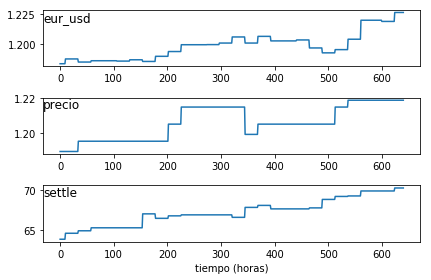

In [96]:
columns = ["eur_usd","precio","settle"]

plt.figure()
for idx,col in enumerate(columns):
    plt.subplot(len(columns),1,idx+1)
    plt.plot(precios_diesel_brent_eurusd_df[col].values)
    plt.title(col, y=0.7, loc='left')
plt.xlabel("tiempo (horas)")
plt.tight_layout()
plt.show()

Finalmente daremos un par de retoques al dataframe final situando la columna label al final del mismo y deshaciéndonos de aquellas features auxiliares que se han utilizado para unir los dataframes.

In [97]:
drop_list = ['dia','hora','fecha_x','fecha_y','fecha_join','ind_24h']

precios_diesel_brent_eurusd_df.drop(columns=drop_list,inplace=True)

In [98]:
precios_diesel_brent_eurusd_df = precios_diesel_brent_eurusd_df[[c for c in precios_diesel_brent_eurusd_df if c not in ['precio_sig']] + ['precio_sig']]

Nos guardaremos la cabecera de nuestro dataframe final (que contiene los nombres de las features y del label)

In [99]:
feature_columns = precios_diesel_brent_eurusd_df.columns

### División del dataframe `precios_diesel_brent_eurusd_df` en conjuntos de `train` y `test`
El tamaño de las series temporales para cada gasolinera no permite poder dividir entre train, validation y test. Así que de cara a esta prueba nos conformamos con train y test.

In [102]:
total_size = len(precios_diesel_brent_eurusd_df)
train_size = np.ceil(total_size * 0.75).astype(int)

In [103]:
precios_values = precios_diesel_brent_eurusd_df.values
train_set = precios_values[:train_size, :]
test_set = precios_values[train_size:, :]

In [104]:
print("Training set con %s ejemplos " % len(train_set))
print("Test set con %s ejemplos " % len(test_set))

Training set con 481 ejemplos 
Test set con 160 ejemplos 


In [105]:
TRAIN_FILE=DATASET_DIR + PRECIO_DIESEL_DATASET_DIR + "\\train_set.csv"
TEST_FILE=DATASET_DIR + PRECIO_DIESEL_DATASET_DIR + "\\test_set.csv"
# There is no pred_set, however we keep the definition in case
# it may be used later.
PRED_FILE=DATASET_DIR + PRECIO_DIESEL_DATASET_DIR + "\\pred_set.csv"

Finalmente guardamos nuestros dataframe de `train` y `test`

In [107]:
pd.DataFrame(data=train_set,columns=feature_columns).to_csv(TRAIN_FILE, sep="|", index=False)
pd.DataFrame(data=test_set,columns=feature_columns).to_csv(TEST_FILE, sep="|", index=False)

### Tensorflow: Dataset API y Estimator API
Ahora es el momento de arrancar con la parte de Tensorflow, lo primero será definir la función que se encargará de cargar y suministrar batches de registros al modelo que más tarde definiremos.

In [122]:
# In case rerrunning is necessary, remove comments from below and start running from here
"""
feature_columns = ['precio', 'precio_premium', 'precio_gasolina_95', 'diff_premium',\
       'ind_diff', 'ind_diff_sig', 'avg_cambios', 'open', 'high', 'low',\
       'settle', 'change', 'wave', 'volume', 'prev_day_open_interest',\
       'efp_volume', 'efs_volume', 'block_volume', 'eur_usd', 'precio_sig']
"""

"\nfeature_columns = ['precio', 'precio_premium', 'precio_gasolina_95', 'diff_premium',       'ind_diff', 'ind_diff_sig', 'avg_cambios', 'open', 'high', 'low',       'settle', 'change', 'wave', 'volume', 'prev_day_open_interest',       'efp_volume', 'efs_volume', 'block_volume', 'eur_usd', 'precio_sig']\n"

In [108]:
import tensorflow as tf

In [116]:
print(tf.__version__)

1.4.0


In [109]:
def dataset_input_fn(file_path, feature_names, batch_size=48, repeat_count=1):
    """
    This function will load the train dataset file and provide with batches of records 
    the Estimator API model based.
    Args:
        - file_path: the path to the training dataset file.
        - feature_names: a list containing the names of the features and the label.
        - batch_size: the number of records that will be fed to the model in each step.
        - repeat_count: the number of epochs (iterations over the whole dataset) that will done. This 
        parameter does not work when used with a customized estimator
    Returns:
        - input_fn: the function that will be invoked to feed the batches to the model.
    """
    def input_fn():
        """
        This function takes care of performing functionality such as decoding each line and 
        checking and filling empty feature values with defaults.
        
        Returns:
            - batch_features: feature values for the current batch.
            - label_features: label values for the current batch.
        """
        #feature_names = ['precio','precio_premium','precio_gasolina_95','diff_premium','ind_diff','ind_diff_sig','avg_cambios','open','high','low','settle','change','wave','volume','prev_day_open_interest','efp_volume','efs_volume','block_volume','eur_usd','precio_sig']
        def has_target(line):
            """
            This is an auxiliar function used to filter out those
            lines that do not have a label (is either missing or NaN)
            Args:
                - line: a record from the file loaded with the Dataset API.
                
            Returns:
                - boolean type: True if the line has a label, False if it does not.
            """
            feat_values = tf.string_split([line,],delimiter="|",skip_empty=False).values
            target_index = tf.size(feat_values) - 1
            empty_target = tf.equal(feat_values[target_index], '')

            if empty_target is True:
                return False
            else:
                return True

        def decode_csv(line):
            """
            This funcion is used to split each line by the indicated separator
            and also fill up the NaN/missing values with some predefined defaults that
            have been carefully chosen form a previous study of the data.
            Args:
                - line: a record from the file loaded with the Dataset API.
            Returns:
                - tuple type: in which the first element will be a dictionary where the keys are the 
                feature names and the values are the feature values. The other element of the tuple is 
                the label.                
            """
            parsed_line = tf.decode_csv(line,\
                                        [[1.169],[1.2432],[1.2588],[60.0],[0.0],[0.0],[0.0],[44.375],[45.25],[43.5],[44.438],[0.059998],[49.812],[42414.0],[80780.0],[1745.0],[868.0],[2392.0],[1.16215],[1.169]],\
                                        field_delim="|")
            label = parsed_line[-1:]
            del parsed_line[-1]
            features = parsed_line
            d = dict(zip(feature_names, features)), label

            return d
        
        imputed_dataset = (tf.data.TextLineDataset(file_path).skip(1).filter(has_target).map(decode_csv))

        imputed_dataset = imputed_dataset.repeat(repeat_count)
        imputed_dataset = imputed_dataset.batch(batch_size)

        batch_features, batch_labels = imputed_dataset.make_one_shot_iterator().get_next()
        return batch_features, batch_labels
    return input_fn


La [API dataset](https://www.tensorflow.org/programmers_guide/datasets) de Tensorflow nos ha permitido definir una función para cargar nuestro dataset e irlo alimentando por medio de batches al modelo. Ahora es momento de definir nuestro modelo ya que tensorflow no proporciona un estimator out of the box para problemas de series temporales.

In [110]:
# Number of LSTM units in the LSTM cell (which is the equivalent to a layer)
LSTM_SIZE = 30
# Number of labels.
N_OUTPUTS=1
# Number of input features.
N_INPUTS=len(feature_columns) - N_OUTPUTS

"""
This functions enables us to define our own model, more accurately, our own Estimator
since Tensorflow does not provide in its current version (1.5) a pre made RNN estimator.
Args:
    - features: this parameter is used to feed the features to the model.
    - labels: this parameter is used to feed the labels to the model.
    - mode: this parameter determines the execution mode (TRAIN, EVAL and PREDICT)
    
Returns:
    - The specifications that fully define the model to be run by an estimator. They must be
    defined for each of the modes (TRAIN, EVAL and PREDICT).
"""
def model_fn(features, labels, mode):
    feature_list = []
    # Each tensor is expanded so it can allocate each batch as n_examples x 1 (since each feature will be a single number)
    for feat,tensor in features.items():
        feature_list += [tf.reshape(tensor,[-1,1])]
        
    # The model architecture is defined.
    lstm_cell = tf.nn.rnn_cell.LSTMCell(LSTM_SIZE, forget_bias=1.0)
    outputs, _ = tf.nn.static_rnn(lstm_cell, feature_list, dtype=tf.float32)
    
    # The last element of the output is the one we want
    outputs = outputs[-1]
    
    # Predictions are calculated, we firstly define the weight and bias
    # which are the parameters the model will tweak to improve its loss.
    weight = tf.Variable(tf.random_normal([LSTM_SIZE, N_OUTPUTS]))
    bias = tf.Variable(tf.random_normal([N_OUTPUTS]))
    predictions = tf.matmul(outputs, weight) + bias
    
    # loss function, training/eval ops are defined
    if mode == tf.estimator.ModeKeys.TRAIN or mode == tf.estimator.ModeKeys.EVAL:
        loss = tf.losses.mean_squared_error(labels, predictions)
        optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
        train_op = optimizer.minimize(loss,tf.train.get_or_create_global_step())
        eval_metric_ops = {
            "rmse": tf.metrics.root_mean_squared_error(labels, predictions)
         }
    else:
        loss = None
        train_op = None
        eval_metric_ops = None
        
    predictions_dict = {"predicted": predictions}
    
    return tf.estimator.EstimatorSpec(mode=mode,\
                                      predictions=predictions_dict,\
                                      loss=loss,\
                                      train_op=train_op,\
                                      eval_metric_ops=eval_metric_ops,\
                                      export_outputs={'classes':tf.estimator.export.PredictOutput(predictions_dict)})

La [API estimator](https://www.tensorflow.org/get_started/custom_estimators) nos ha permitido definir una nuestro propio modelo a través de una función. Vemos que no solo consiste en en definir el modelo sino en especificar las operaciones propias de cada modo de ejecución TRAIN, EVAL y PREDICT.
Ahora es el momento de definir la estructura que recibirá las features de entrada: el `ServingInputReceiver`, se puede pensar en él como un diccionario de tensores que proporcionará el espacio necesario donde almacenar las features que se le pasarán al modelo.

In [111]:
def serving_input_fn():
    """
    This function is intended to provide some kind of dictionary in
    which each input feature (note that the label is not included here) is 
    associated with a please where the values associated to each feature will 
    be allocated before being fed to the model.
    Returns
        - ServingInputReceiver: the structure associating each feature with its
        corresponding placeholder.
    """
    feature_placeholders = {}
    for i in range(len(feature_columns)-1):
        feature_placeholders[feature_columns[i]] = tf.placeholder(tf.float32, [None])
    """
    This code is listed here just for information
    
    feature_placeholders = {
        'precio': tf.placeholder(tf.float32, [None]),
        'precio_premium': tf.placeholder(tf.float32, [None]),
        'precio_gasolina_95': tf.placeholder(tf.float32, [None]),        
        'diff_premium': tf.placeholder(tf.float32, [None]),
        'ind_diff': tf.placeholder(tf.float32, [None]),
        'ind_diff_sig': tf.placeholder(tf.float32, [None]),
        'avg_cambios': tf.placeholder(tf.float32, [None]),
        'open': tf.placeholder(tf.float32, [None]),
        'high': tf.placeholder(tf.float32, [None]),
        'low': tf.placeholder(tf.float32, [None]),
        'settle': tf.placeholder(tf.float32, [None]),
        'change': tf.placeholder(tf.float32, [None]),
        'wave': tf.placeholder(tf.float32, [None]),
        'volume': tf.placeholder(tf.float32, [None]),
        'prev_day_open_interest': tf.placeholder(tf.float32, [None]),
        'efp_volume': tf.placeholder(tf.float32, [None]),
        'efs_volume': tf.placeholder(tf.float32, [None]),
        'block_volume': tf.placeholder(tf.float32, [None]),
        'eur_usd': tf.placeholder(tf.float32, [None])              
    }
    """
    features = {
      key: tf.expand_dims(tensor, -1)
      for key, tensor in feature_placeholders.items()
    }
    
    return tf.estimator.export.ServingInputReceiver(
      features,      
      feature_placeholders
    )

In [112]:
# We use this library to delete the whole directory containing
# previous checkpoints and graphs
import shutil

En el siguiente código destaca `tf.estimator.Estimator` que recibirá la función `model_fn` definida previamente y que nos devuelve el EstimatorSpec en el que se encapsula lo necesario para poder realizar entrenamiento, evaluación o predicciones sobre el modelo.
También hay que destacar el `tf.estimator.LatestExporter` que se encarga de exportar regularmente los checkpoints y el grafo de nuestro modelo, para posteriormente poder ejecutar la predicción sobre el o continuar el entrenamiento a partir de un determinado checkpoint.
Finalmente `tf.estimator.train_and_evaluate` permite entrenar y evaluar el modelo de acuerdo con las especificaciones que hayamos definido mediante `tf.estimator.TrainSpec` y `tf.estimator.EvalSpec`.
Nota: al utilizar `tf.estimator.TrainSpec`, el valor de `max_steps` a través del cual se define el número de steps de entrenamiento anulará cualquier valor que hayamos especificado en nuestra función `dataset_input_fn` para `repeat_count`. Si no especificamos `max_steps` el entrenamiento se ejecutará indefinidamente. En resumidas cuentas `repeat_count` no tiene efecto alguno.

In [117]:
training_config = tf.estimator.RunConfig(save_checkpoints_steps=10)
hparams = None

estimator = tf.estimator.Estimator(model_fn=model_fn,\
                                   model_dir="C:\\Cursos\\DeepLearning_TF-master\\models",\
                                   config=training_config,\
                                    params=hparams)
        
train_spec = tf.estimator.TrainSpec(input_fn=dataset_input_fn(TRAIN_FILE, feature_columns), max_steps=100)
exporter = tf.estimator.LatestExporter('exporter', serving_input_fn)
eval_spec = tf.estimator.EvalSpec(input_fn=dataset_input_fn(TEST_FILE, feature_columns),\
                                 steps=None,\
                                 exporters=exporter)
# start fresh each time deleting saved checkpoints and graphs
shutil.rmtree("C:\\Cursos\\DeepLearning_TF-master\\models\\", ignore_errors=True)
tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)


INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': None, '_num_worker_replicas': 1, '_task_id': 0, '_master': '', '_log_step_count_steps': 100, '_num_ps_replicas': 0, '_model_dir': 'C:\\Cursos\\DeepLearning_TF-master\\models', '_keep_checkpoint_max': 5, '_is_chief': True, '_save_checkpoints_steps': 10, '_task_type': 'worker', '_session_config': None, '_service': None, '_save_checkpoints_secs': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002508A4F3908>, '_save_summary_steps': 100}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 600 secs (eval_spec.throttle_secs) or training is finished.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Cursos\DeepLearning_TF-master\models\model.ckpt.
INFO:tensorflow:loss = 0.2876508, step = 1
INFO:tensorflow:Saving checkpoin

INFO:tensorflow:Saving checkpoints for 78 into C:\Cursos\DeepLearning_TF-master\models\model.ckpt.
INFO:tensorflow:loss = 0.00038406835, step = 78
INFO:tensorflow:Saving checkpoints for 88 into C:\Cursos\DeepLearning_TF-master\models\model.ckpt.
INFO:tensorflow:Loss for final step: 0.00020442491.
INFO:tensorflow:Starting evaluation at 2018-02-09-12:19:26
INFO:tensorflow:Restoring parameters from C:\Cursos\DeepLearning_TF-master\models\model.ckpt-88
INFO:tensorflow:Finished evaluation at 2018-02-09-12:19:28
INFO:tensorflow:Saving dict for global step 88: global_step = 88, loss = 0.0003651888, rmse = 0.019203747
INFO:tensorflow:Restoring parameters from C:\Cursos\DeepLearning_TF-master\models\model.ckpt-88
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b"C:\\Cursos\\DeepLearning_TF-master\\models\\export\\exporter\\temp-b'1518178769'\\saved_model.pb"
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring pa

Finalmente, cuando se quiera hacer predicciones en base al modelo entrenado, usaremos el fichero pred.csv (que ya declaramos en la variable `PRED_FILE` y en cada línea introduciremos todas las features con las que hemos entrenado el modelo. Realizando a continuación la siguiente invocación:

In [119]:
predictions = estimator.predict(input_fn=dataset_input_fn(PRED_FILE, feature_columns))

In [121]:
print(list(predictions))

INFO:tensorflow:Restoring parameters from C:\Cursos\DeepLearning_TF-master\models\model.ckpt-100
[{'predicted': array([1.4148873], dtype=float32)}]
